In [155]:
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [171]:
def preprocessing(words):
    unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

    def contains_unwanted_chars(word):
        return any(char in unwanted_chars for char in word)

    words = [haiku.replace("/", "").replace("  ", " ") + "." for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]
    return words

def load_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    words = preprocessing(words)
    return words

def load_tsv_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    # take the fist column
    words = [line.split('\t')[1][:-1] for line in words]
    words = preprocessing(words)
    return words

words = load_tsv_data('../data/dev.tsv') + load_tsv_data('../data/test.tsv') + load_tsv_data('../data/train.tsv') + load_data('../data/lines.txt')
chars = sorted(list(set(''.join(words)))) #+ ["<S>", "<M>", "<E>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [174]:
class CharDataset(Dataset):
    def __init__(self, words, chars, max_word_length):
        self.words = words
        self.chars = chars
        self.max_word_length = max_word_length
        self.stoi = {ch:i+1 for i,ch in enumerate(chars)}
        self.itos = {i:s for s,i in self.stoi.items()}

    def __len__(self):
        return len(self.words)

    def contains(self, word):
        return word in self.words

    def get_vocab_size(self):
        return len(self.chars) + 1

    def get_output_length(self):
        return self.max_word_length + 1

    def encode(self, word):
        ix = torch.tensor([self.stoi[w] for w in word], dtype=torch.long)
        return ix

    def decode(self, ix):
        word = ''.join(self.itos[i] for i in ix)
        return word

    def __getitem__(self, idx):
        word = self.words[idx]
        ix = self.encode(word)
        x = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        y = torch.zeros(self.max_word_length + 1, dtype=torch.long)
        x[1:1+len(ix)] = ix
        y[:len(ix)] = ix
        y[len(ix)+1:] = -1 

        return x, y
    
class GRUCell(nn.Module):
    """
    same job as RNN cell, but a bit more complicated recurrence formula
    that makes the GRU more expressive and easier to optimize.
    """
    def __init__(self, config):
        super().__init__()
        # input, forget, output, gate
        self.xh_to_z = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_r = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.xh_to_hbar = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        # first use the reset gate to wipe some channels of the hidden state to zero
        xh = torch.cat([xt, hprev], dim=1)
        r = F.sigmoid(self.xh_to_r(xh))
        hprev_reset = r * hprev
        # calculate the candidate new hidden state hbar
        xhr = torch.cat([xt, hprev_reset], dim=1)
        hbar = F.tanh(self.xh_to_hbar(xhr))
        # calculate the switch gate that determines if each channel should be updated at all
        z = F.sigmoid(self.xh_to_z(xh))
        # blend the previous hidden state and the new candidate hidden state
        ht = (1 - z) * hprev + z * hbar
        return ht

class RNNCell(nn.Module):
    """
    the job of a 'Cell' is to:
    take input at current time step x_{t} and the hidden state at the
    previous time step h_{t-1} and return the resulting hidden state
    h_{t} at the current timestep
    """
    def __init__(self, config):
        super().__init__()
        # self.wxh_to_h = torch.randn(config.n_embd + config.n_embd2, config.n_embd2) * 5/3 / math.sqrt(config.n_embd + config.n_embd2)
        # self.bxh_to_h = torch.zeros(config.n_embd2) * 0
        self.xh_to_h = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)

    def forward(self, xt, hprev):
        xh = torch.cat([xt, hprev], dim=1)
        # ht = torch.tanh(xh @ self.wxh_to_h + self.bxh_to_h)
        ht = torch.tanh(self.xh_to_h(xh))
        return ht

class RNN(nn.Module):

    def __init__(self, config, cell="rnn"):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2))
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        if cell == "rnn":
            self.cell = RNNCell(config)
        elif cell == "gru":
            self.cell = GRUCell(config)
        self.out_cell = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):
        b, t = idx.size()

        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        emb = self.wte(idx)
        hprev = self.start.expand((b, -1))
        hiddens = []

        for i in range(t):
            xt = emb[:, i, :]
            ht = self.cell(xt, hprev)
            hprev = ht
            hiddens.append(ht)

        hidden = torch.stack(hiddens, 1)
        logits = self.out_cell(hidden)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

def train_rnn(model, batch_loader, epochs=50000, learning_rate=0.01):
    optimizer = torch.optim.AdamW(model.parameters(), 
                                lr=learning_rate, 
                                weight_decay=0.01, 
                                betas=(0.9, 0.99), 
                                eps=1e-8)
    all_losses = []
    all_iters = []
    
    for epoch in range(epochs):
        batch = batch_loader.next()
        X, Y = batch

        # feed into the model
        _, loss = model(X, Y)

        # backprop
        model.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"step {epoch} | loss {loss.item():.4f}")

        all_losses.append(loss.item())
        all_iters.append(epoch)

    return all_losses, all_iters

def create_datasets(words, chars):
    # words = open(input_file, 'r').read().splitlines()
    # words = preprocessing(words)
    # words = [w.replace("/", "").replace("$", "").replace("  ", " ").strip() for w in words] 
    # words = [w for w in words if w]
    # chars = sorted(list(set(''.join(words))))
    max_word_length = max(len(w) for w in words)
    
    test_set_size = min(1000, int(len(words) * 0.1))
    rp = torch.randperm(len(words)).tolist()
    train_words = [words[i] for i in rp[:-test_set_size]]
    test_words = [words[i] for i in rp[-test_set_size:]]
    print(f"split up the dataset into {len(train_words)} training examples and {len(test_words)} test examples")

    # wrap in dataset objects
    train_dataset = CharDataset(train_words, chars, max_word_length)
    test_dataset = CharDataset(test_words, chars, max_word_length)

    return train_dataset, test_dataset


In [177]:
class InfiniteDataLoader:
    def __init__(self, dataset, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=True, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration:
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch

@dataclass
class ModelConfig:
    block_size: int = None
    vocab_size: int = None
    n_embd: int = 64
    n_embd2: int = 64

train_dataset, test_dataset = create_datasets(words, chars)
vocab_size = train_dataset.get_vocab_size()
block_size = train_dataset.get_output_length()
config = ModelConfig(vocab_size=vocab_size, block_size=block_size)

print(f"vocab size: {vocab_size}")
print(f"block size: {block_size}")

batch_loader = InfiniteDataLoader(train_dataset, batch_size=128)
model = RNN(config)

split up the dataset into 11335 training examples and 1000 test examples
vocab size: 46
block size: 121


In [178]:
all_losses_rnn, all_iters_rnn = train_rnn(model, batch_loader, epochs=1000)

step 0 | loss 3.8625
step 10 | loss 2.4779
step 20 | loss 2.2838
step 30 | loss 2.2301
step 40 | loss 2.1412
step 50 | loss 2.0819
step 60 | loss 2.0428
step 70 | loss 2.0192
step 80 | loss 2.0026
step 90 | loss 1.9908
step 100 | loss 1.9468
step 110 | loss 1.9265
step 120 | loss 1.9259
step 130 | loss 1.9457
step 140 | loss 1.8788
step 150 | loss 1.8712
step 160 | loss 1.8737
step 170 | loss 1.9258
step 180 | loss 1.8642
step 190 | loss 1.8575
step 200 | loss 1.8272
step 210 | loss 1.8241
step 220 | loss 1.8350
step 230 | loss 1.8354
step 240 | loss 1.8354
step 250 | loss 1.8178
step 260 | loss 1.8298
step 270 | loss 1.7811
step 280 | loss 1.8423
step 290 | loss 1.7977
step 300 | loss 1.8087
step 310 | loss 1.7732
step 320 | loss 1.7978
step 330 | loss 1.8094
step 340 | loss 1.7539
step 350 | loss 1.7826
step 360 | loss 1.8099
step 370 | loss 1.8139
step 380 | loss 1.7930
step 390 | loss 1.7817
step 400 | loss 1.7780
step 410 | loss 1.7763
step 420 | loss 1.7642
step 430 | loss 1.7625

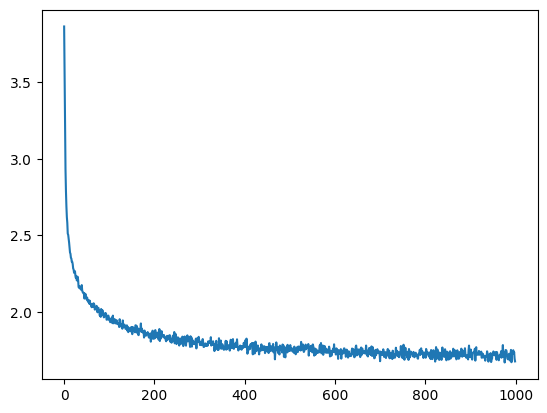

In [179]:
import matplotlib.pyplot as plt
plt.plot(all_iters_rnn, all_losses_rnn)

In [183]:
@torch.inference_mode()
def evaluate(model, dataset, batch_size=50, max_batches=None):
    model.eval()
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        # batch = [t.to(args.device) for t in batch]
        X, Y = batch
        _, loss = model(X, Y)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss

evaluate(model, train_dataset, batch_size=128), evaluate(model, test_dataset, batch_size=128)

(1.7140601873397827, 1.7168246507644653)

In [180]:
gru_model = RNN(config, cell="gru")
batch_loader = InfiniteDataLoader(train_dataset, batch_size=128)
all_losses_gru, all_iters_gru = train_rnn(gru_model, batch_loader, epochs=1000)

step 0 | loss 3.8575
step 10 | loss 2.5654
step 20 | loss 2.3169
step 30 | loss 2.1916
step 40 | loss 2.1263
step 50 | loss 2.0647
step 60 | loss 2.0263
step 70 | loss 1.9597
step 80 | loss 1.9241
step 90 | loss 1.8966
step 100 | loss 1.8586
step 110 | loss 1.8674
step 120 | loss 1.8154
step 130 | loss 1.7954
step 140 | loss 1.8054
step 150 | loss 1.7524
step 160 | loss 1.7445
step 170 | loss 1.7807
step 180 | loss 1.7703
step 190 | loss 1.7536
step 200 | loss 1.7233
step 210 | loss 1.7302
step 220 | loss 1.7303
step 230 | loss 1.7373
step 240 | loss 1.6901
step 250 | loss 1.6771
step 260 | loss 1.7436
step 270 | loss 1.6931
step 280 | loss 1.7139
step 290 | loss 1.6537
step 300 | loss 1.6759
step 310 | loss 1.6408
step 320 | loss 1.6697
step 330 | loss 1.6640
step 340 | loss 1.6536
step 350 | loss 1.6273
step 360 | loss 1.6483
step 370 | loss 1.6572
step 380 | loss 1.6566
step 390 | loss 1.6150
step 400 | loss 1.6186
step 410 | loss 1.6366
step 420 | loss 1.6377
step 430 | loss 1.6158

In [184]:
evaluate(gru_model, train_dataset, batch_size=128), evaluate(gru_model, test_dataset, batch_size=128)

(1.5669128894805908, 1.5835411548614502)

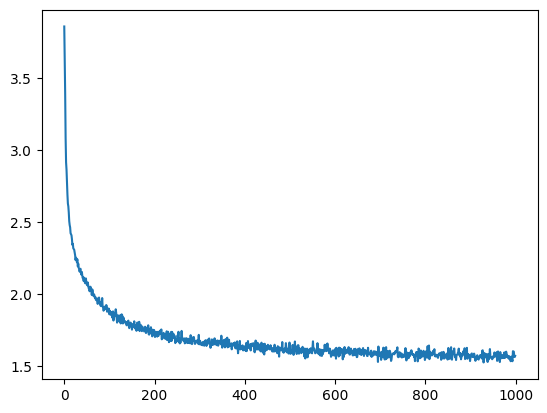

In [185]:
import matplotlib.pyplot as plt
plt.plot(all_iters_gru, all_losses_gru)

## Comparable loss to Single Layer NN -> which is weird cause RNN is supposed to do better?

In [240]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def print_samples(num, model):
    X_init = torch.zeros(num, 1, dtype=torch.long)
    top_k = 4
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(model, X_init, steps, top_k=top_k, do_sample=True).to('cpu')
    train_samples, test_samples, new_samples = [], [], []
    for i in range(X_samp.size(0)):
        row = X_samp[i, 1:].tolist()
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        word_samp = train_dataset.decode(row)
        if train_dataset.contains(word_samp):
            train_samples.append(word_samp)
        elif test_dataset.contains(word_samp):
            test_samples.append(word_samp)
        else:
            new_samples.append(word_samp)
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            print(word.replace("/", "").replace("$", "").replace("  ", "").replace(" .", "."))
    print('-'*80)


print_samples(num=10, model=model)
print_samples(num=10, model=gru_model)

--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
the she sof a to strenking the rind.
surmand.
a tip i hants than.
i have think.
i wind the bany strops the prenession too to what should and my sears the pong all.
a truite is stink.
streating a time ared.
and sun.
is a was the bristenting sunseting.
someth are in minges so me.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
the findlow and hide the mouse of love so the water the minded a sharp.
i have i am all is a prey before strong is my bed is my bloat.
the mountains in the still to shirling all a beaut in me forevine.
stars are tree to lanctage shalled i am another be from the surrowe.
sun side in a storm in the sun alwhere the 

## LSTM

In [211]:
# Inefficient implementation

class LSTMCell(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.stm = torch.zeros((config.vocab_size + 1, config.n_embd2))
        self.ltm = torch.zeros((config.vocab_size + 1, config.n_embd2))
        self.wforget = {
            "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
            "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
        }
        self.winput = {
            "pltm": {
                "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
                "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
            }, 
            "popltm": {
                "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
                "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
            }
        }
        self.woutput = {
            "stm": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2),
            "input": nn.Linear(in_features=config.n_embd, out_features=config.n_embd2)
        }
    
    def forward(self, xt):
        # forget gate
        xf = self.wforget["input"](xt)
        stmf = self.wforget["stm"](self.stm)

        # print(xf.shape, stmf.shape)

        fin = torch.sigmoid(xf + stmf)
        self.ltm *= fin

        #input gate
        xi = self.winput["pltm"]["input"](xt)
        stmi = self.winput["pltm"]["stm"](self.stm)
        io = torch.tanh(xi + stmi)

        xip = self.winput["popltm"]["input"](xt)
        stmip = self.winput["popltm"]["stm"](self.stm)
        iof = torch.sigmoid(xip + stmip)

        self.ltm += (iof * io)

        # output gate
        xo = self.woutput["input"](xt)
        stmo = self.woutput["stm"](self.stm)
        aux_out = torch.sigmoid(xo + stmo)

        fout = aux_out * (torch.tanh(self.ltm))
        self.stm = fout

        return fout
    
class LSTMCellEfficient(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.n_embd2
        self.weight = nn.Linear(config.n_embd + config.n_embd2, 4 * config.n_embd2)
        # self.dropout = nn.Dropout(p=0.2)  # Adding dropout
        # self.layer_norm = nn.LayerNorm(config.n_embd2)
        # self.dropout = nn.Dropout(p=0.2)
    def forward(self, xt, stm, ltm):
        combined = torch.cat((xt, stm), dim=-1)
        gates = self.weight(combined)
        f_gate, i_gate, o_gate, g_gate = gates.chunk(4, dim=-1)

        f_gate = torch.sigmoid(f_gate)
        i_gate = torch.sigmoid(i_gate)
        o_gate = torch.sigmoid(o_gate)
        g_gate = torch.tanh(g_gate)

        ltm = f_gate * ltm + i_gate * g_gate
        stm = o_gate * torch.tanh(ltm)

        # stm = self.layer_norm(stm)
        # stm = self.dropout(stm)

        return stm, ltm

In [218]:
def train_rnn(model, config, batch_loader, epochs=50000, steps_per_epoch=100, learning_rate=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    all_losses = []
    all_iters = []

    for epoch in range(epochs):
        stm = torch.zeros(32, config.n_embd2)  # Reset STM at the beginning of each epoch
        ltm = torch.zeros(32, config.n_embd2)
        print(f"Epoch {epoch}")
        for step in range(steps_per_epoch):  # Process multiple batches in an epoch
            batch = batch_loader.next()  # Fetch next batch explicitly
            X, Y = batch

            # Forward pass
            stm, ltm, loss, _ = model(X, Y, stm, ltm)

            # Backpropagation
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            # Detach STM and LTM to prevent computational graph buildup
            stm = stm.detach()
            ltm = ltm.detach()

            if step % 10 == 0:
                print(f"Step: {step}, Loss: {loss.item():.4f}")

        all_losses.append(loss.item())
        all_iters.append(epoch)

    return all_losses, all_iters


In [219]:
class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2))
        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.cell = LSTMCellEfficient(config)
        self.out_cell = nn.Linear(config.n_embd2, self.vocab_size)

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None, ltm=None, stm=None):
        b, t = idx.size()

        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        emb = self.wte(idx)
        hiddens = []

        for i in range(t):
            xt = emb[:, i, :]
            stm, ltm = self.cell(xt, stm, ltm)
            hiddens.append(stm)

        hidden = torch.stack(hiddens, 1)
        logits = self.out_cell(hidden)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return stm, ltm, loss, logits   


In [221]:
batch_loader = InfiniteDataLoader(train_dataset, batch_size=32)
lstm = RNN(config)
all_losses, all_iters = train_rnn(lstm, config, batch_loader, epochs=20)

Epoch 0
Step: 0, Loss: 3.7996
Step: 10, Loss: 2.7348
Step: 20, Loss: 2.4310
Step: 30, Loss: 2.3130
Step: 40, Loss: 2.2196
Step: 50, Loss: 2.1616
Step: 60, Loss: 2.1502
Step: 70, Loss: 2.0313
Step: 80, Loss: 2.0837
Step: 90, Loss: 2.0488
Epoch 1
Step: 0, Loss: 2.0875
Step: 10, Loss: 2.0277
Step: 20, Loss: 1.9815
Step: 30, Loss: 1.9638
Step: 40, Loss: 1.9759
Step: 50, Loss: 1.9235
Step: 60, Loss: 1.9064
Step: 70, Loss: 1.9566
Step: 80, Loss: 1.8676
Step: 90, Loss: 1.9382
Epoch 2
Step: 0, Loss: 1.9472
Step: 10, Loss: 1.8981
Step: 20, Loss: 1.8974
Step: 30, Loss: 1.8716
Step: 40, Loss: 1.8914
Step: 50, Loss: 1.8631
Step: 60, Loss: 1.9002
Step: 70, Loss: 1.8445
Step: 80, Loss: 1.8415
Step: 90, Loss: 1.8681
Epoch 3
Step: 0, Loss: 1.9295
Step: 10, Loss: 1.8468
Step: 20, Loss: 1.8203
Step: 30, Loss: 1.8238
Step: 40, Loss: 1.8321
Step: 50, Loss: 1.7457
Step: 60, Loss: 1.8120
Step: 70, Loss: 1.8500
Step: 80, Loss: 1.7919
Step: 90, Loss: 1.7632
Epoch 4
Step: 0, Loss: 1.7987
Step: 10, Loss: 1.8018

In [223]:
@torch.inference_mode()
def evaluate(model, dataset, batch_size=50, max_batches=None):
    model.eval()
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    losses = []
    for i, batch in enumerate(loader):
        # batch = [t.to(args.device) for t in batch]
        X, Y = batch
        ltm = torch.zeros(X.size(0), config.n_embd2, device=X.device)
        stm = torch.zeros(X.size(0), config.n_embd2, device=X.device)
        stm, ltm, loss, _ = model(X, Y, stm, ltm)
        losses.append(loss.item())
        if max_batches is not None and i >= max_batches:
            break
    mean_loss = torch.tensor(losses).mean().item()
    model.train() # reset model back to training mode
    return mean_loss

evaluate(lstm, test_dataset, batch_size=64), evaluate(lstm, train_dataset, batch_size=64)

(1.6525046825408936, 1.651007890701294)

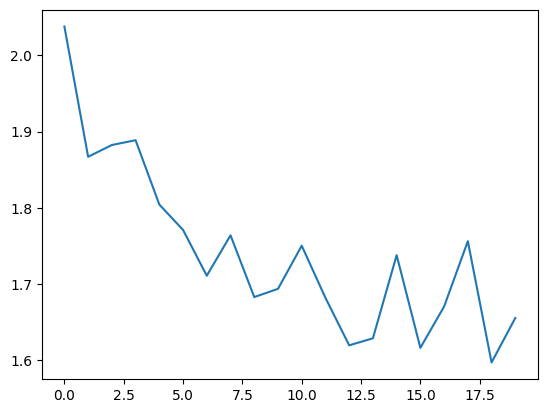

In [222]:
import matplotlib.pyplot as plt
plt.plot(all_iters, all_losses)

In [237]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        stm = torch.zeros(10, config.n_embd2, device=X.device)
        ltm = torch.zeros(10, config.n_embd2, device=X.device)
        _, _, _, logits = model(idx_cond, stm=stm, ltm=ltm)
        logits = logits[:, -1, :] / temperature
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

def print_samples(num=10):
    X_init = torch.zeros(num, 1, dtype=torch.long)
    top_k = 3
    steps = train_dataset.get_output_length() - 1 # -1 because we already start with <START> token (index 0)
    X_samp = generate(lstm, X_init, steps, top_k=top_k, do_sample=True).to('cpu')
    train_samples, test_samples, new_samples = [], [], []
    for i in range(X_samp.size(0)):
        row = X_samp[i, 1:].tolist()
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        word_samp = train_dataset.decode(row)
        if train_dataset.contains(word_samp):
            train_samples.append(word_samp)
        elif test_dataset.contains(word_samp):
            test_samples.append(word_samp)
        else:
            new_samples.append(word_samp)
    print('-'*80)
    for lst, desc in [(train_samples, 'in train'), (test_samples, 'in test'), (new_samples, 'new')]:
        print(f"{len(lst)} samples that are {desc}:")
        for word in lst:
            print(word.replace("/", "").replace("$", "").replace("  ", "").replace(" .", "."))
    print('-'*80)


print_samples(num=10)

--------------------------------------------------------------------------------
0 samples that are in train:
0 samples that are in test:
10 samples that are new:
i am the break.
i sade.
things the beautifully all a light.
the call and to branched.
the can an on the sky a life.
time today an the can it there alone to time the still a love and today a see than.
an and till the can think the skys the so a bright.
the still and the skin the bring.
the sky the beautiful the chank a life all the compers and the bed and the can in my lovers and there a loved is a seare
that i hair the come the stream.
--------------------------------------------------------------------------------
